## 1. Connect to google drive

Connect to google drive to store data from the test.

In [1]:
# Connect to MyDrive for now, change location when running locally
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


#### Install dependencies

In [2]:
! pip install wget onnxruntime

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.9 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=162bd1c79185039a542f48e1e17143124eb7c5740401fb09df9cd4d63a8b516a
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


#### Run functions cells to instantiate them

In [3]:
import IPython

def gpu_info():
    try:
        gpu_name = IPython.get_ipython().getoutput('nvidia-smi --query-gpu=gpu_name --format=csv,noheader')
        return gpu_name[0].strip() if gpu_name else None
    except Exception as e:
        print(f"Error: {e}")
        return None


gpu_name = gpu_info()

if gpu_name:
    print(f"GPU Name: {gpu_name}")
else:
    print("No GPU information available.")

GPU Name: Tesla T4


In [4]:
import torch, time, argparse, requests, wget, onnxruntime, tarfile, os, cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from urllib.parse import urlparse
import pandas as pd

def run_on_gpu(model, model_name, device_name, input_tensor, device):
    """Running Regular PyTorch Models"""


    # Model -> GPU
    model.to(device)
    input_tensor = input_tensor.to(device)

    model.eval()

    # Avoid timing fluctuations
    with torch.no_grad():
        _ = model(input_tensor)


    num_iterations = 100  # Adjust Parameter based on experiments
    total_time = 0.0

    for _ in range(num_iterations):
        start_time = time.time()

        with torch.no_grad():
            output = model(input_tensor)

        end_time = time.time()
        iteration_time = end_time - start_time
        total_time += iteration_time

    average_time = total_time / num_iterations
    print(f"Average inference time on {device}: {average_time:.6f} seconds")

    # Update Data File; change file_path when using locally:
    file_path = f'./drive/MyDrive/GPU_benchmarks/gpu_latency_data_{model_name}.txt'
    update_gpu_latency(file_path, device_name, average_time)
    print(f"Average inference time on {device_name}: {average_time:.6f} seconds")
    plot_latency(file_path)

def download_and_load_onnx_model(link_to_tar, model_file_name):
    """Downloads Link to raw tar files from ONNX
    GitHub Repository and runs an inference session"""

    # Colab Local Folder, needs to be changed in other places:
    download_dir = "/content"
    tar_file_path = os.path.join(download_dir, model_file_name + ".tar")
    wget.download(link_to_tar, tar_file_path)

    # Extracting
    with tarfile.open(tar_file_path, 'r:gz') as tar:
        tar.extractall(download_dir)

    # Load ONNX model
    onnx_model_path = os.path.join(download_dir, model_file_name, model_file_name + ".onnx")
    session = onnxruntime.InferenceSession(onnx_model_path,
                                           providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

    return session

# Custom Preprocess for Yolov4 ONNX Models

def image_preprocess(image, target_size, gt_boxes=None):

    ih, iw = target_size
    h, w, _ = image.shape

    scale = min(iw/w, ih/h)
    nw, nh = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_padded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_padded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_padded = image_padded / 255.

    if gt_boxes is None:
        return image_padded

    else:
        gt_boxes[:, [0, 2]] = gt_boxes[:, [0, 2]] * scale + dw
        gt_boxes[:, [1, 3]] = gt_boxes[:, [1, 3]] * scale + dh
        return image_padded, gt_boxes

def is_valid_url(url):
    try:
        result = urlparse(url)
        return all([result.scheme, result.netloc])
    except ValueError:
        return False

def download_model_from_github(github_url, save_path):
    response = requests.get(github_url)
    with open(save_path, 'wb') as file:
        file.write(response.content)


In [15]:
%matplotlib inline

def run_onnx_gpu(onnx_session, model_name, device, test_img):
    """
    Args: Onnx sessions, image from Ultralytics website
    """
    # Running ONNX Models
    input_size = 416

    if not os.path.exists(test_img):
        wget.download("https://ultralytics.com/images/bus.jpg", test_img)

    test_img = cv2.imread(test_img)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img_size = test_img.shape[:2]

    img_data = image_preprocess(np.copy(test_img), [input_size, input_size])
    img_data = img_data[np.newaxis, ...].astype(np.float32)

    outputs = onnx_session.get_outputs()
    output_names = list(map(lambda output: output.name, outputs))
    input_name = onnx_session.get_inputs()[0].name

    num_iterations = 100
    total_time = 0.0

    for _ in range(num_iterations):
        start_time = time.time()
        detection = onnx_session.run(output_names, {input_name: img_data})
        end_time = time.time()

        iteration_time = end_time - start_time
        total_time += iteration_time

    average_time = total_time / num_iterations

    # Update Data File; change file_path when using locally:
    file_path = f'./drive/MyDrive/GPU_benchmarks/gpu_latency_data_{model_name}.txt'
    update_gpu_latency(file_path, device, average_time)
    print(f"Average inference time on {device}: {average_time:.6f} seconds")
    plot_latency(file_path)


def update_gpu_latency(file_path, gpu_name, latency):
    # Check folder if it doesn't exist. Change if running locally.
    folder_path = "./drive/MyDrive/GPU_benchmarks/"
    if not os.path.exists(folder_path):
            os.makedirs(folder_path)
            print(f"Folder created at: {folder_path}")

    # Create the file if it doesn't exist.
    if not os.path.exists(file_path):
        with open(file_path, 'w') as file:
            pass

        print(f"File created at: {file_path}")

    try:
        # Read existing data from the file
        with open(file_path, 'r') as file:
            lines = file.readlines()

        # Check if the GPU name is already in the file
        found = False
        for i, line in enumerate(lines):
            if gpu_name in line:
                # Update if the GPU already exits
                lines[i] = f"{gpu_name}, {latency}\n"
                found = True
                break

        # If GPU name is not found, append a new entry
        if not found:
            lines.append(f"{gpu_name}, {latency}\n")

        # Write the updated data back to the file
        with open(file_path, 'w') as file:
            file.writelines(lines)

        print(f"Data updated successfully for GPU: {gpu_name}")

    except Exception as e:
        print(f"Error: {e}")


def plot_latency(file_path):
    try:
        df = pd.read_csv(file_path, header=None, names=['gpu_name', 'latency'])

        model_name = file_path.split("_")[-1]
        model_name = os.path.splitext(model_name)[0]
        # Create a bar graph
        plt.barh(df['gpu_name'], df['latency'], color='skyblue', height=0.5)
        plt.xlabel('Latency')
        plt.ylabel('GPU Name')
        plt.title(f'GPU Latency for {model_name}')
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

In [ ]:
def run_pytorch_hub_gpu(model, model_name, device, test_data):
    """
    Load models using pytorch_hub
    """
    # One image batch for inference
    if not os.path.exists(test_data):
        torch.hub.download_url_to_file('https://ultralytics.com/images/' + test_data, test_data)

    #img = Image.open(test_data)
    img = cv2.imread(test_data)

    num_iterations = 100
    total_time = 0.0

    for _ in range(num_iterations):
        start_time = time.time()
        results = model([img])
        end_time = time.time()

        iteration_time = end_time - start_time
        total_time += iteration_time

    average_time = total_time / num_iterations

    # Update Data File; change file_path when using locally:
    file_path = f'./drive/MyDrive/GPU_benchmarks/gpu_latency_data_{model_name}.txt'
    update_gpu_latency(file_path, device, average_time)
    print(f"Average inference time on {device}: {average_time:.6f} seconds")
    plot_latency(file_path)


## 2. Testing ONNX Yolo Model

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Data updated successfully for GPU: Tesla T4
Average inference time on Tesla T4: 0.397479 seconds


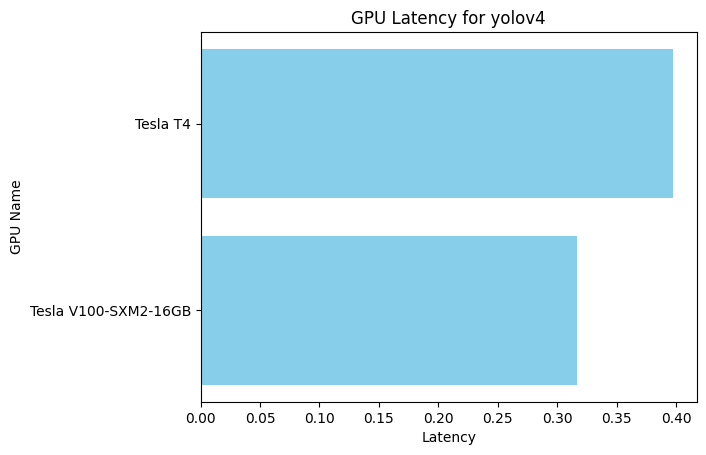

In [ ]:
# Testing ONNX Model Yolov4:

# Replace with other models links
model_link = "https://github.com/onnx/models/raw/main/archive/vision/object_detection_segmentation/yolov4/model/yolov4.tar.gz"
model_name = "yolov4"

onnx_session = download_and_load_onnx_model(model_link, model_name)

run_onnx_gpu(onnx_session, model_name, gpu_name, "bus.jpg")


## Testing PyTorch Models
1. Run the PyTorch YOLO model. Can be replaced by other models from PyTorh Hub.
2. Run second cell to generate the graph.

In [7]:
# PyTorch Hub Models
# Replace with other model links from PyTorch Hub.
pytorch_model_name = 'yolov5l'
model = torch.hub.load('ultralytics/yolov5',
                       pytorch_model_name, pretrained=True)



/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


requirements: Ultralytics requirements ['gitpython>=3.1.30', 'Pillow>=10.0.1'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 239.5 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0

requirements: AutoUpdate success ✅ 6.4s, installed 2 packages: ['gitpython>=3.1.30', 'Pillow>=10.0.1']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2023-12-18 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 89.3M/89.3M [00:01<00:00, 50.9MB/s]

Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients, 109.0 GFLOPs
Adding AutoShape... 


Data updated successfully for GPU: Tesla T4
Average inference time on Tesla T4: 0.027437 seconds


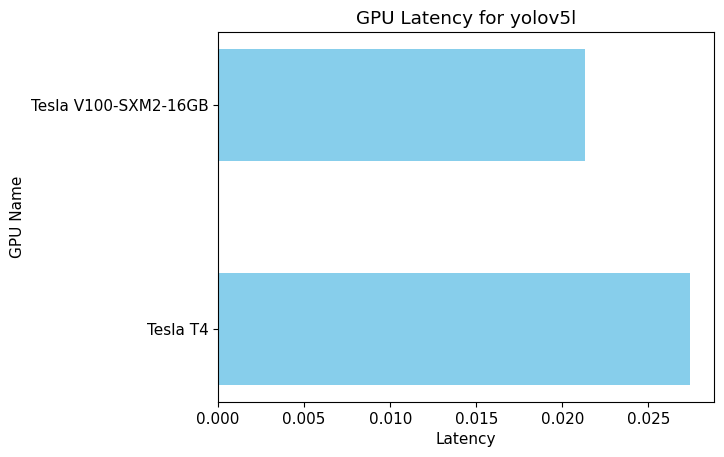

In [16]:
%matplotlib inline
# Graph cell

run_pytorch_hub_gpu(model, pytorch_model_name, gpu_name, "bus.jpg")

## Testing Custom Model  Inference
1. Develop your own model and try usin to test GPUs.
2. Example below shows a sample model and how it is saved and loaded later to run benchmarking test.
3. If you have access to a PyTorch 'pth' file and change the load function by giving path to it.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        # ResNet18 as a base model
        self.resnet18 = resnet18(pretrained=False)
        in_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet18(x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pre-processing
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load training dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

# Initialize  model, loss function, and optimizer
num_classes = 10  # CIFAR-10 has 10 classes
model = CustomCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

100%|██████████| 170498071/170498071 [00:05<00:00, 29751477.78it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/5], Loss: 1.7089
Epoch [2/5], Loss: 2.6902
Epoch [3/5], Loss: 1.6209
Epoch [4/5], Loss: 1.1809
Epoch [5/5], Loss: 1.3072


In [ ]:
# Training
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save trained model -> '.pth' file
torch.save(model.state_dict(), './drive/MyDrive/GPU_benchmarks/custom_cnn_model.pth')

### Inference
1. Previous cell saves the model to a path in the google drive. Change path to run your own model.

Average inference time on cuda: 0.003106 seconds
Data updated successfully for GPU: Tesla T4
Average inference time on Tesla T4: 0.003106 seconds


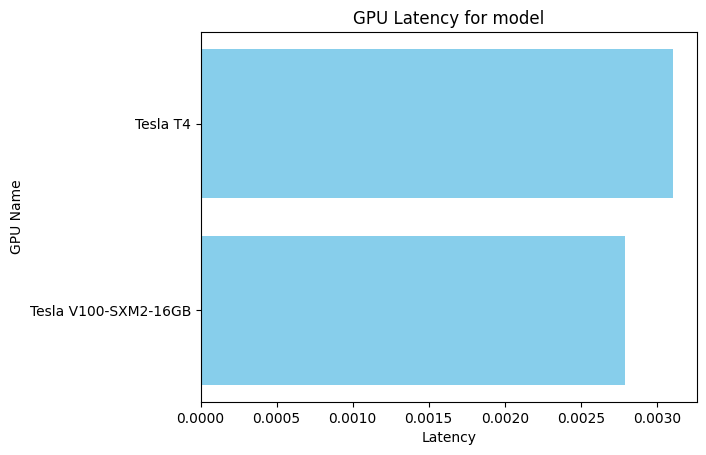

In [ ]:
PATH = "./drive/MyDrive/GPU_benchmarks/custom_cnn_model.pth"

img = cv2.imread('bus.jpg')
model_name = 'custom_cnn_model'
sample_img = torch.randn(1, 3, 224, 224)

model = CustomCNN(num_classes=num_classes)
model.load_state_dict(torch.load(PATH))

run_on_gpu(model, model_name, gpu_name, sample_img, device)
